# call the libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline,PipelineModel
from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql.functions import udf, col
from pyspark.sql.types import *
import numpy as np
from pyspark.ml.feature import MinMaxScaler

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
import numpy as np

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go



import numpy as np
import plotly
init_notebook_mode(connected=True)
%matplotlib inline



# initialize spark and spark context

In [2]:
spark = SparkSession.builder.appName('demo-anomaly-profile-dome9-ip-pyspark-kmeans-batch-score').getOrCreate()
sc = spark.sparkContext
sc.version

'2.1.1'

In [3]:
data_source = "dome9"
tenant_name = "demo"
time_window="day"
entity_type="ip"
anomaly_type="profile"
model_type="pyspark"
model_name="kmeans"

BASE_PATH = "/Users/tuhinsharma/Documents/sstech/"+tenant_name
ANOMALY_DATA_REPOSITORY = BASE_PATH + "/models_data/data"

USER_PROFILE_DATA_PATH = ANOMALY_DATA_REPOSITORY + "/{data_source}/{entity_type}/{anomaly_type}/{time_window}.json"
data_path = USER_PROFILE_DATA_PATH.format\
                                           (data_source=data_source,\
                                            entity_type=entity_type,anomaly_type="profile",time_window=time_window)
    
ANOMALY_MODEL_REPOSITORY = BASE_PATH + "/models_data/model"
PROFILE_ANOMALY_MODEL_PATH = ANOMALY_MODEL_REPOSITORY + "/{data_source}/{entity_type}/{anomaly_type}/{time_window}/{model_type}/{model_name}"




# lets load the Profile data for DOME9 with 3 attributes

In [4]:
ip_profile_sdf = spark.read.json(data_path).persist()
ip_profile_sdf.show(3)

+------------------+-----------------+----------------+-----------+-------------------+-----------+
|inbound_conn_count|increase_activity|lateral_movement|logon_count|outbound_conn_count|     src_ip|
+------------------+-----------------+----------------+-----------+-------------------+-----------+
|              1446|            False|           False|        655|               1115|  54.85.1.3|
|              1421|            False|           False|        635|               1115| 54.85.5.15|
|              1392|             True|           False|        629|               1090|54.85.10.16|
+------------------+-----------------+----------------+-----------+-------------------+-----------+
only showing top 3 rows



### Load the Clustering Pipelinemodel

In [5]:
model_path = PROFILE_ANOMALY_MODEL_PATH.format(data_source=data_source,\
                                  entity_type=entity_type,anomaly_type=anomaly_type,time_window=time_window,\
                                 model_type=model_type,model_name=model_name)

In [6]:

clustering_pipeline_model = PipelineModel.load(model_path+"/clustering_pipeline_model")


### Load the Scoring Pipelinemodel

In [7]:
scoring_pipeline_model = PipelineModel.load(model_path+"/scoring_pipeline_model")


### calculate sum of euclidean distance

In [8]:
def calculate_SED_from_all_centroids(value,centroids):
    single_point = value
    points = centroids

    dist = (points - single_point)**2
    dist = np.sum(dist, axis=1)
    dist = np.sqrt(dist)
    dist = np.sum(dist)
    return float(dist)

def udf_calculate_SED(centroid_list):
    return udf(lambda l: calculate_SED_from_all_centroids(l, centroid_list),FloatType())


### Calculate scaled sed on a scale ( 0 - 1 )

In [9]:
result_cluster_sdf = clustering_pipeline_model.transform(ip_profile_sdf)
centroids = np.array(clustering_pipeline_model.stages[-1].clusterCenters())
result_sed_sdf = result_cluster_sdf.withColumn("sed", udf_calculate_SED(centroids)(col("features")))
result_scaler_sdf = scoring_pipeline_model.transform(result_sed_sdf).persist()
result_scaler_sdf.show(3)

+------------------+-----------------+----------------+-----------+-------------------+-----------+-----------------------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+----------+---------+-------------------+--------------------+
|inbound_conn_count|increase_activity|lateral_movement|logon_count|outbound_conn_count|     src_ip|increase_activity_index|lateral_movement_index|increase_activity_vec|lateral_movement_vec|        features_vec|         features_zs|            features|cluster_id|      sed|            sed_vec|          scaled_sed|
+------------------+-----------------+----------------+-----------+-------------------+-----------+-----------------------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+----------+---------+-------------------+--------------------+
|              1446|            False|           False|

### Anomaly Score on a scale ( 0 - 100 )

In [10]:
def format_anomaly_score(value):
    val = float(value[0])*100
    if val > 100:
        return 100.0
    if val < 0:
        return 0.0
    return val

udf_format_anomaly_score = udf(format_anomaly_score,FloatType())
result_score_sdf = result_scaler_sdf.withColumn("PAS", udf_format_anomaly_score("scaled_sed"))
result_score_sdf.show(3)

+------------------+-----------------+----------------+-----------+-------------------+-----------+-----------------------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+----------+---------+-------------------+--------------------+----------+
|inbound_conn_count|increase_activity|lateral_movement|logon_count|outbound_conn_count|     src_ip|increase_activity_index|lateral_movement_index|increase_activity_vec|lateral_movement_vec|        features_vec|         features_zs|            features|cluster_id|      sed|            sed_vec|          scaled_sed|       PAS|
+------------------+-----------------+----------------+-----------+-------------------+-----------+-----------------------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+----------+---------+-------------------+--------------------+----------+
|              1446|  

## stats for PAS

In [11]:
result_score_sdf.select("PAS").describe().show()

+-------+------------------+
|summary|               PAS|
+-------+------------------+
|  count|              1059|
|   mean| 23.34748635602881|
| stddev|19.616309506491927|
|    min|               0.0|
|    max|             100.0|
+-------+------------------+



# get binary response as normal/anomaly

In [12]:
def is_anomaly(value):
    if value > 60:
        return 1
    else:
        return 0
udf_is_anomaly = udf(is_anomaly,IntegerType())
result_score_sdf = result_score_sdf.withColumn("anomaly", udf_is_anomaly("PAS"))
result_score_sdf.show(4)

+------------------+-----------------+----------------+-----------+-------------------+-----------+-----------------------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+----------+---------+-------------------+--------------------+----------+-------+
|inbound_conn_count|increase_activity|lateral_movement|logon_count|outbound_conn_count|     src_ip|increase_activity_index|lateral_movement_index|increase_activity_vec|lateral_movement_vec|        features_vec|         features_zs|            features|cluster_id|      sed|            sed_vec|          scaled_sed|       PAS|anomaly|
+------------------+-----------------+----------------+-----------+-------------------+-----------+-----------------------+----------------------+---------------------+--------------------+--------------------+--------------------+--------------------+----------+---------+-------------------+--------------------+----------+-------

# get the normal records

In [13]:
normal_sdf = result_score_sdf.where(result_score_sdf['anomaly'] == 0)
normal_sdf.select("anomaly").distinct().show()
print("normal record count {count}".format(count=normal_sdf.count()))

+-------+
|anomaly|
+-------+
|      0|
+-------+

normal record count 1053


# get the anomaly records

In [14]:
anomaly_sdf = result_score_sdf.where(result_score_sdf['anomaly'] == 1)
anomaly_sdf.select("anomaly").distinct().show()
print("anomaly record count {count}".format(count=anomaly_sdf.count()))

+-------+
|anomaly|
+-------+
|      1|
+-------+

anomaly record count 6


In [15]:
normal_logon_count = normal_sdf.rdd.map(lambda x: x["logon_count"]).collect()
normal_inbound_conn_count = normal_sdf.rdd.map(lambda x: x["inbound_conn_count"]).collect()
normal_outbound_conn_count = normal_sdf.rdd.map(lambda x: x["outbound_conn_count"]).collect()

anomaly_logon_count = anomaly_sdf.rdd.map(lambda x: x["logon_count"]).collect()
anomaly_inbound_conn_count = anomaly_sdf.rdd.map(lambda x: x["inbound_conn_count"]).collect()
anomaly_outbound_conn_count = anomaly_sdf.rdd.map(lambda x: x["outbound_conn_count"]).collect()


# static 3d visualization

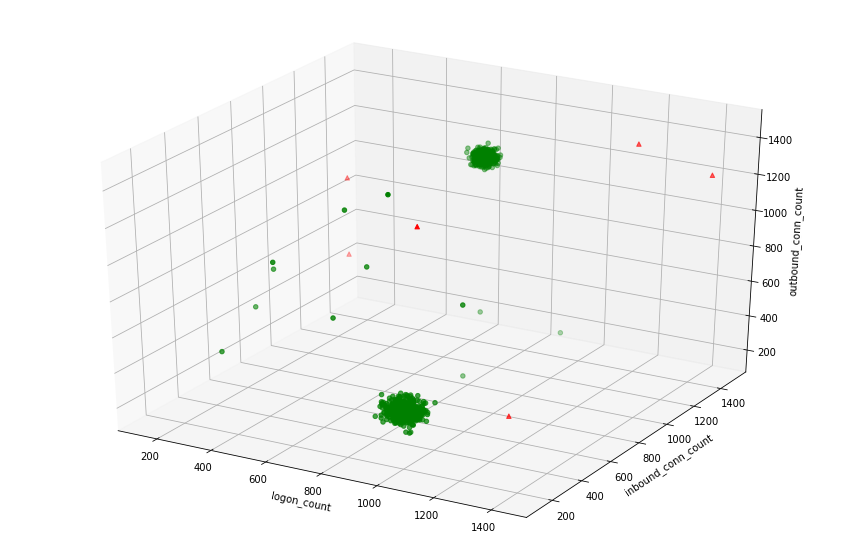

In [16]:
plt.close()

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

xs = normal_logon_count
ys = normal_inbound_conn_count
zs = normal_outbound_conn_count
ax.scatter(xs, ys, zs, c="g", marker="o")

xs = anomaly_logon_count
ys = anomaly_inbound_conn_count
zs = anomaly_outbound_conn_count
ax.scatter(xs, ys, zs, c="r", marker="^")

ax.set_xlabel('logon_count')
ax.set_ylabel('inbound_conn_count')
ax.set_zlabel('outbound_conn_count')

plt.show()
plt.close()

# interactive 3d visualization

In [17]:
normal = go.Scatter3d(
    x=normal_logon_count,
    y=normal_inbound_conn_count,
    z=normal_outbound_conn_count,
    mode='markers',
    marker=dict(
        color='rgb(200, 200, 200)',
        size=8,
        line=dict(
            color='rgb(217, 217, 217)',
            width=0.5
        ),
        opacity=0
    ),
    name="normal"
)

anomaly = go.Scatter3d(
    x=anomaly_logon_count,
    y=anomaly_inbound_conn_count,
    z=anomaly_outbound_conn_count,
    mode='markers',
    marker=dict(
        color='rgb(255, 0, 0)',
        size=8,
        line=dict(
            color='rgb(217, 0, 0)',
            width=0.5
        ),
        opacity=0
    ),
    name="anomaly"
)

data = [normal,anomaly]

layout = go.Layout(
    title='Pyspark Kmeans',
    scene = dict(
        xaxis = dict(
            title='logon_count'),
        yaxis = dict(
            title='in_conn_count'),
        zaxis = dict(
            title='out_conn_count'),),
    autosize=False,
    width=1000,
    height=700,
                  )
fig = go.Figure(data=data, layout=layout)
iplot(figure_or_data=fig)